# COVID-19 Situation Reports


# Analysis and Prediction using Supervised Learning Regression

In [27]:
%matplotlib inline

# Packages used in the notebook
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.svm import SVR
from sklearn.base import clone
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [28]:
# function used to call train_test_split to split the data in 75% for training and 25% for testing
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# function used to train the model (search) with the training data (in_train, out_train), also gives the time elapsed
def train_model(params, search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    print('Best score: {}'.format(search.best_score_))
    print('Best parameters: {}'.format(search.best_params_))
    return search.best_estimator_
    
# function used to fit normally a model (search) with the training data (in_train, out_train), also gives the time elapsed.
# this function is used as an alternative to train_model, when the hyper parameter tuning is takes too long to complete,
# and is not a feasible option.
def fit_model(search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    return search
    
# function used to plot a bar graph to compare the data ploted using the trained model (estimator) with the actual real results (out_test)
# Also gives some statistical parameters like the Mean Absolute Error (MAE),Mean Squared Error (MSE), Root Mean Squared Error (RMSE)
# and finally the (R^2).
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
# function used to calculate and plot the cross validation score when using a trained model (estimator) and applying it
# to the inputs (inputs) and finally comparing it with the outputs (outputs).
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
# function used to convert data from increments into cumulative data   
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
# function used to predict  a attribute (output), for a certain country (country) using as input an array of 
# attributes (inputs_list). This prediction is done using a trained model (estimator) and using input and output data 
# from the certain country (country_inputs, country_outputs). When cumulative is True it means we are predicting
# a cumulative attribute and otherwise a incremental attribute.
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()
    
# function used to plot a learning curve using a trained model (estimator) and inputs (inputs) and outputs(outputs)
# to test the model itself
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
# function used to plot a bar graph representing the diference between the actual output values  for a country (country_outputs),
# obtained using the "output" variable ,and the ones predicted by a trained model (estimator) for a certain attribute (output) using 
# as input an array of values (country_inputs) obtained from the array "inputs_list" for that certain country
def plot_pred_diff(df, estimator, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()

## 3) Prediction and Regression
### 3.5) Support Vector Machines
- - -

In [29]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


### Approach (Support Vector Machine)

#### Brief description of the algorithm

In machine learning, support-vector machines (SVMs, also known as support-vector networks) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis.

In a formal way, a support-vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class (so-called functional margin), since in general the larger the margin, the lower the generalization error of the classifier.

#### Steps taken to make the algorith start predicting values

For this task we use the SVR class from Scikit Learn.

In order to make SVR start predicting values the first step needed was to do hyper parameter tuning using cross validation, for that reason, function RandomizedSearchCV() was used from sktlearn. The scoring value used by RandomizedSearchCV() to evaluate parameters was the negative mean squared error (scoring='neg_mean_squared_error'), this value as used since it is a default metric for the evaluation of the performance of most regression algorithms. For the cross validation part of this function, times of processing were evaluated and it was decided to use a 3-fold strategy with 10 iterations.

After that the model was trained using training data and at the end the model was ready to be tested and used to predict values.
It was decided it would be in the best of interests to predict values for the confimed cases first, using the following combinations of inputs and outputs:

1) Using normalized values as input and using cummulative as output
   * inputs: lat_norm, long_norm, num_days_from_begin_norm
   * outputs: confirmed
   
2) Using normalized values as input and using increments as output
   * inputs: lat_norm, long_norm, num_days_from_begin_norm
   * outputs: confirmed_inc

3) Using non normalized values as input and using increments as output
   * inputs: lat, long, num_days_from_begin
   * outputs: confirmed_inc
    
4) Using increments in confirmed cases and normalized values, using increments as output
   * inputs: lat_norm, long_norm, num_days_from_begin_norm, confirmed_inc_day_before_norm
   * outputs: confirmed_inc
    
From this four combinations, one was chosen, the one with the best predictions, and used to predict the deaths and the recovered number of cases. In order to find out which combination was the best, a number of scalar parameters like the MAE, MSE, RMSE and R^2 were used to compare iterations aswell as some graphs. In the end it was discovered that the best combination was the third one using as input the normalized values of the lat, long, num_days_from_begin and confirmed_inc_day_before and as output the increment in confirmed cases.

In order to compare values in a consistent way all the graphs related to countries were always made for the same 6 countries: US, Spain, Portugal, Italy, Russia and Brazil.

### 3.5.1) Regression for confirmed cases
- - -

#### 3.5.1.1) Using normalized values as input and using increases as output

In [4]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [5]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [6]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [7]:
# create SVM instance, and check the hyper parameters
svm = SVR()
svm.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [8]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(svm, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.8min finished


Elapsed time: 7.28323046763738mins
Best score: -1659521.0841862306
Best parameters: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 1, 'C': 1}


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 156.24617065823696
MSE: 1718611.033393193
RMSE: 1310.9580593570463
R^2: -0.013907168688009675


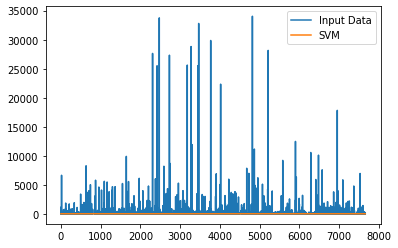

In [9]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM')

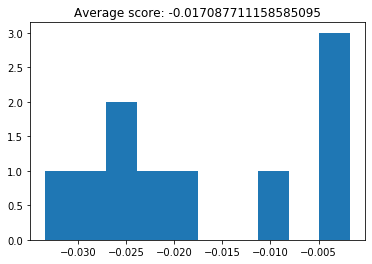

In [10]:
# check the score obtained by doing cross validation with the data
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

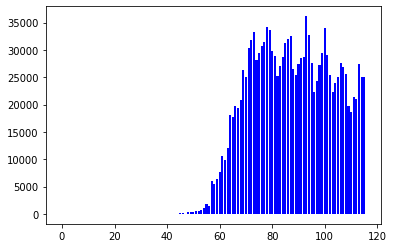

In [15]:
# check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    df, svm_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed_inc"
)

MAE: 355363.6252150369
MSE: 358243384184.1517
RMSE: 598534.3634112846
R^2: -0.5440367202703258


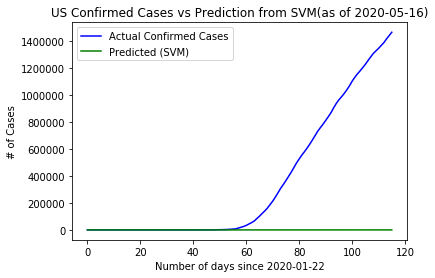

In [11]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    df, "US", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "US Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 81934.22140457242
MSE: 15281547366.162544
RMSE: 123618.55591359473
R^2: -0.7647054037855372


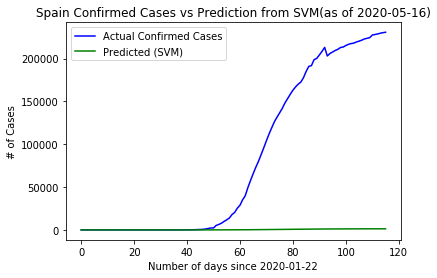

In [18]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    df, "Spain", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Spain Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 30361.386951564513
MSE: 3904068669.44097
RMSE: 62482.54691864737
R^2: -0.3076085681208789


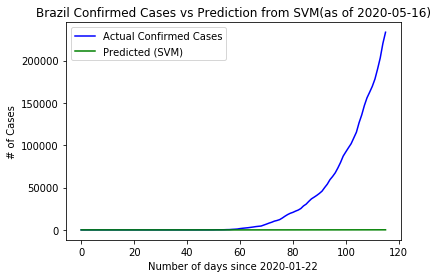

In [12]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    df, "Brazil", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Brazil Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 8656.521465412638
MSE: 188234273.4496024
RMSE: 13719.849614686102
R^2: -0.6397569844951578


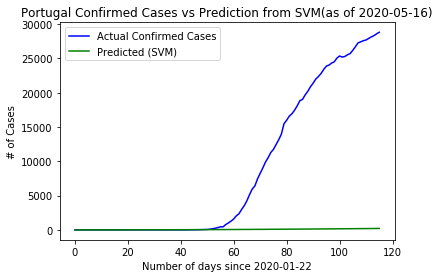

In [13]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    df, "Portugal", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Portugal Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 36455.28023566339
MSE: 6120892869.680589
RMSE: 78236.13531917709
R^2: -0.27455211674061086


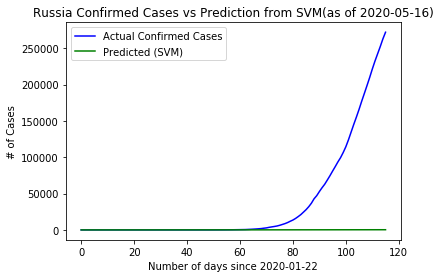

In [14]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    df, "Russia", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Russia Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 82784.6255488043
MSE: 14385273217.640978
RMSE: 119938.62271028869
R^2: -0.9069179060807191


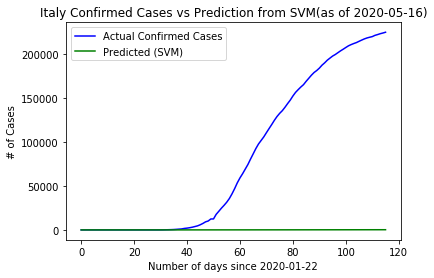

In [15]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    df, "Italy", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Italy Confirmed Cases vs Prediction from SVM",
    True
)

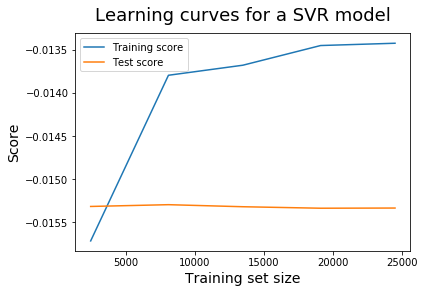

In [16]:
# compute the learning curve for the estimator, using the inputs and outputs
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

#### 3.5.1.2) Using non normalized values as input and using increments as output

In [30]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [31]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [32]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [33]:
# fit the model with the train set
search = SVR()
svm_estimator = fit_model(search, in_conf_train, out_conf_train)
svm_estimator

Elapsed time: 0.5360531171162923mins


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 145.70046683454405
MSE: 1249041.334786244
RMSE: 1117.6051783998873
R^2: -0.013641552343972574


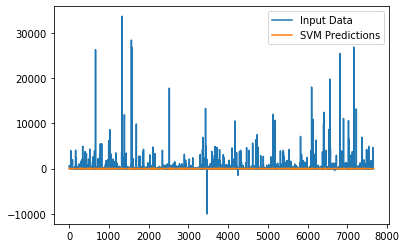

In [34]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM Predictions')

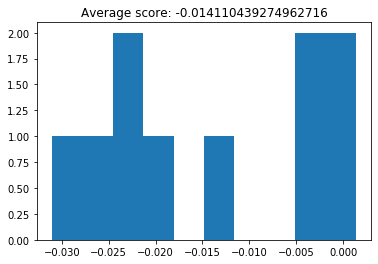

In [35]:
# check the score obtained by doing cross validation with the data
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

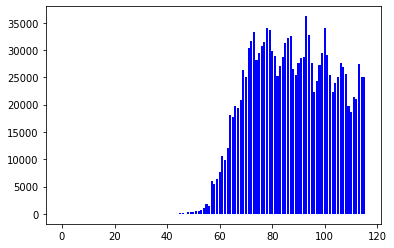

In [36]:
# check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    df, svm_estimator,
    "US", 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

MAE: 355361.3244080924
MSE: 358216578276.6606
RMSE: 598511.9700362396
R^2: -0.5439211862303024


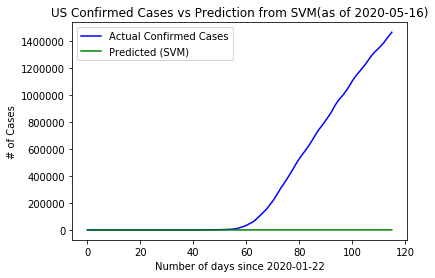

In [37]:
 # generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    df, "US", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "US Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 82088.84397868761
MSE: 15340793519.414162
RMSE: 123857.95702906682
R^2: -0.7715471197643875


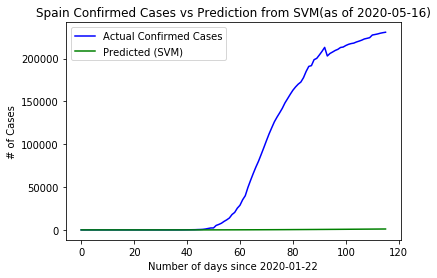

In [38]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    df, "Spain", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Spain Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 30318.137820937747
MSE: 3897988325.084467
RMSE: 62433.8716169714
R^2: -0.30557204902993074


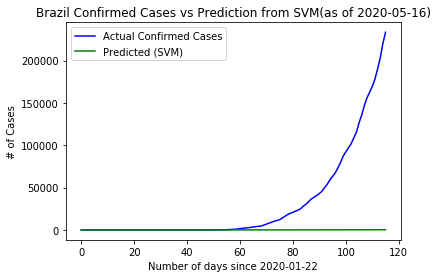

In [39]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    df, "Brazil", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Brazil Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 8492.809187323151
MSE: 181077199.0655636
RMSE: 13456.492821889498
R^2: -0.5774098757847925


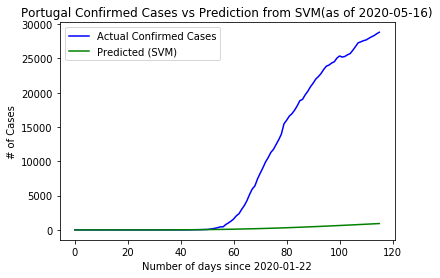

In [40]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    df, "Portugal", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Portugal Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 36374.68561031272
MSE: 6096983020.628386
RMSE: 78083.18013905674
R^2: -0.2695733743627813


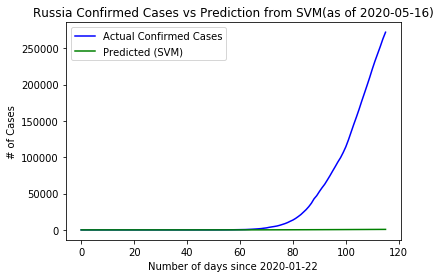

In [41]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    df, "Russia", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Russia Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 82459.93744538579
MSE: 14263255168.45573
RMSE: 119428.8707493114
R^2: -0.8907431418384211


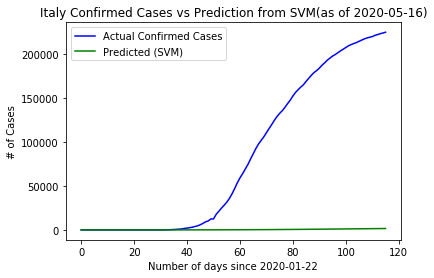

In [42]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    df, "Italy", svm_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Italy Confirmed Cases vs Prediction from SVM",
    True
)

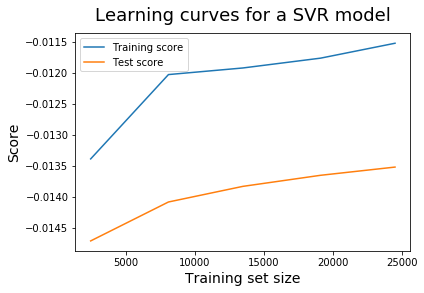

In [43]:
# compute the learning curve for the estimator, using the inputs and outputs
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

#### 3.2.1.3) Using increments in confirmed cases and normalized values, using increments as output

In [44]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [45]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = new_df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [46]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [47]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.4min finished


Elapsed time: 4.56763987938563mins
Best score: -154338.60538471385
Best parameters: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.1, 'C': 1}


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 44.30396416858946
MSE: 158200.00450949385
RMSE: 397.74364169587153
R^2: 0.9130242500831625


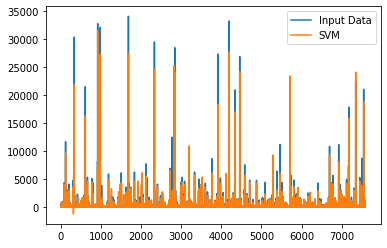

In [48]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM')

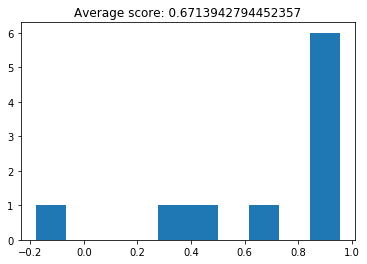

In [49]:
# check the score obtained by doing cross validation with the data
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

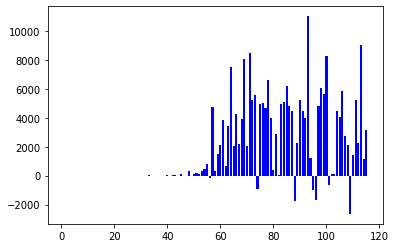

In [50]:
# check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    new_df, svm_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

MAE: 56742.52936333717
MSE: 8227522687.577414
RMSE: 90705.69269664068
R^2: 0.9646776552161792


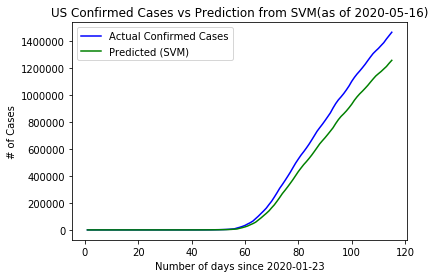

In [51]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    new_df, "US", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "US Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 12313.551768780359
MSE: 314035329.0804192
RMSE: 17721.041986305972
R^2: 0.9638014478914646


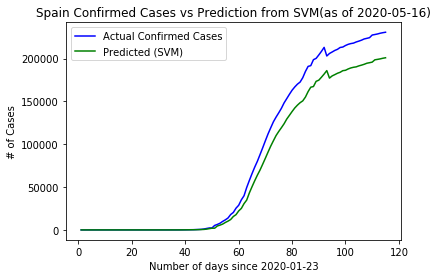

In [52]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    new_df, "Spain", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Spain Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 5665.979630224423
MSE: 130290352.98470362
RMSE: 11414.479969963748
R^2: 0.9566208329676154


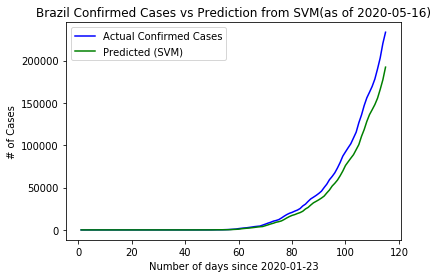

In [53]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    new_df, "Brazil", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Brazil Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 1333.3689399994912
MSE: 4030304.6130164117
RMSE: 2007.5618578306403
R^2: 0.9649919735399944


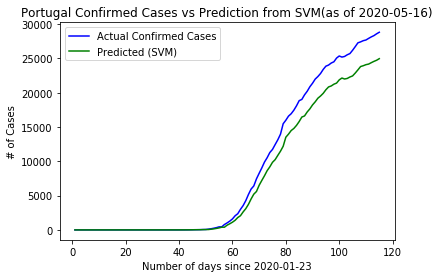

In [54]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    new_df, "Portugal", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Portugal Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 6748.2612698189405
MSE: 188429843.424413
RMSE: 13726.975028184943
R^2: 0.9610073121433482


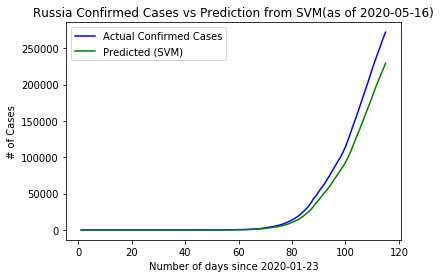

In [55]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    new_df, "Russia", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Russia Confirmed Cases vs Prediction from SVM",
    True
)

MAE: 12332.988184538655
MSE: 290408372.3933114
RMSE: 17041.372374116803
R^2: 0.9615307591288602


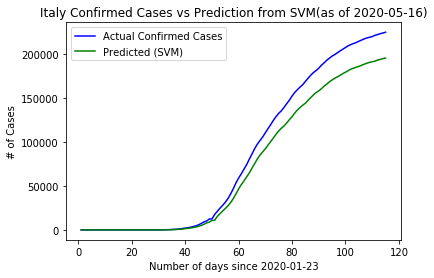

In [56]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    new_df, "Italy", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Italy Confirmed Cases vs Prediction from SVM",
    True
)

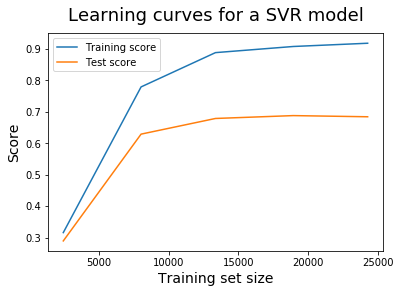

In [58]:
# compute the learning curve for the estimator, using the inputs and outputs
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

#### 3.2.1.4) Using normalized values as input and using cummulative as output

In [59]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [60]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42])

In [61]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [62]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min finished


Elapsed time: 3.1571537335713704mins
Best score: -1702326606.3913538
Best parameters: {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.01, 'C': 1}


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 4240.13873837966
MSE: 1571700839.3747516
RMSE: 39644.682359362545
R^2: -0.010058788267568897


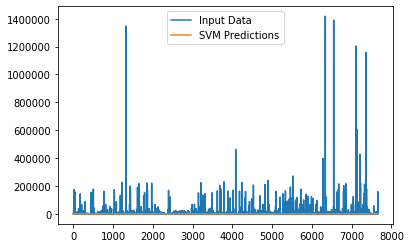

In [63]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM Predictions')

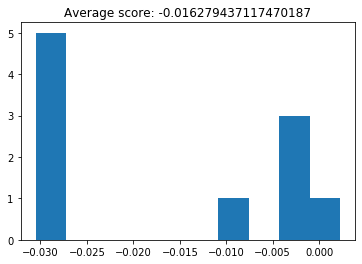

In [64]:
# check the score obtained by doing cross validation with the data
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

MAE: 355345.4435924577
MSE: 358196342632.1628
RMSE: 598495.0648352606
R^2: -0.5438339701656316


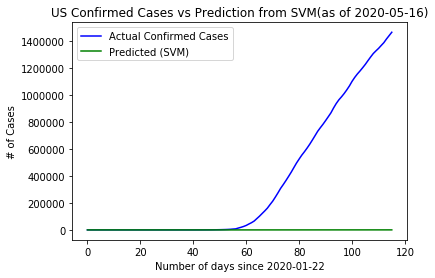

In [65]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    df, "US", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "US Confirmed Cases vs Prediction from SVM"
)

MAE: 82191.37650349968
MSE: 15385639501.177502
RMSE: 124038.8628663513
R^2: -0.7767259111825309


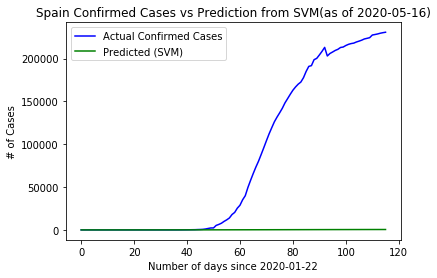

In [66]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    df, "Spain", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Spain Confirmed Cases vs Prediction from SVM"
)

MAE: 30346.94681960351
MSE: 3901420814.9300475
RMSE: 62461.35457168734
R^2: -0.306721709425815


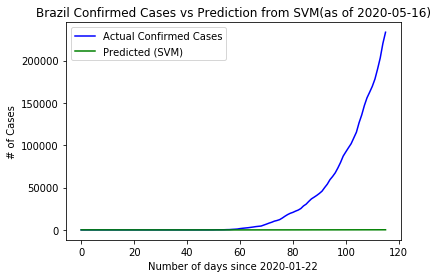

In [67]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    df, "Brazil", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Brazil Confirmed Cases vs Prediction from SVM"
)

MAE: 8571.633887821657
MSE: 184829702.34063834
RMSE: 13595.208800920946
R^2: -0.6100988932622191


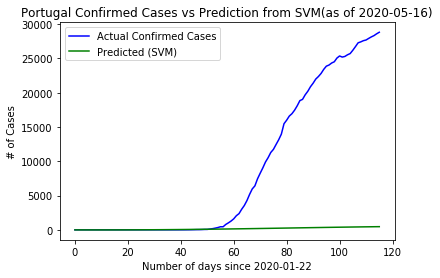

In [68]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    df, "Portugal", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Portugal Confirmed Cases vs Prediction from SVM"
)

MAE: 36349.22414097353
MSE: 6096333006.670112
RMSE: 78079.01771071478
R^2: -0.2694380221055097


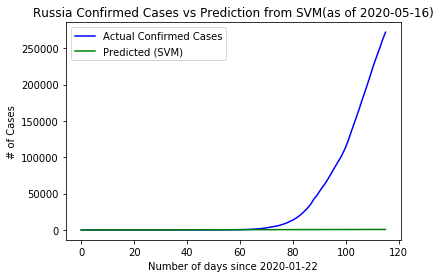

In [69]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    df, "Russia", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Russia Confirmed Cases vs Prediction from SVM"
)

MAE: 82672.47073493856
MSE: 14348882304.262913
RMSE: 119786.82024439464
R^2: -0.9020939112014166


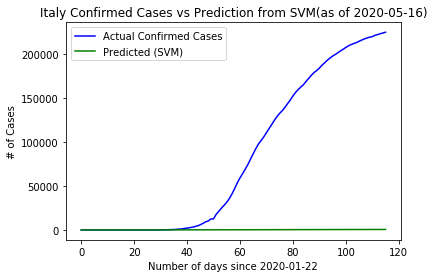

In [70]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    df, "Italy", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SVM)", 
    "Italy Confirmed Cases vs Prediction from SVM"
)

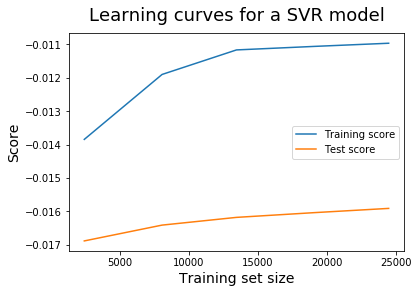

In [71]:
# compute the learning curve for the estimator, using the inputs and outputs
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

### 3.5.2) Regression for Death Cases
#### Using the best combination of parameters found for the confirmed cases, for SVM the best option was using increments in death cases and normalized values, using increments as output

In [72]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Deaths_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11017732],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11017732],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11017732],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11017732],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11017732],
       [-1.65599721,  0.09994051,  1.71718314, -0.11017732]])

In [73]:
# get the output for the machine learning algorithm (death cases)
outputs = new_df["Deaths_inc"].values
outputs

array([0., 0., 0., ..., 0., 0., 0.])

In [74]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [75]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished


Elapsed time: 1.7417657017707824mins
Best score: -989.8603669584605
Best parameters: {'kernel': 'linear', 'gamma': 1, 'epsilon': 0.1, 'C': 0.1}


SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 3.374868272206406
MSE: 1028.2477920874585
RMSE: 32.06630306236531
R^2: 0.888949140999406


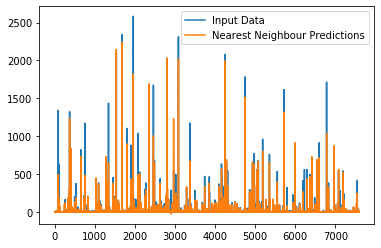

In [76]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

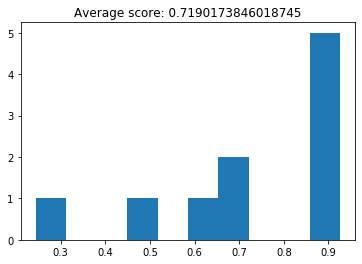

In [77]:
# check the score obtained by doing cross validation with the data
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

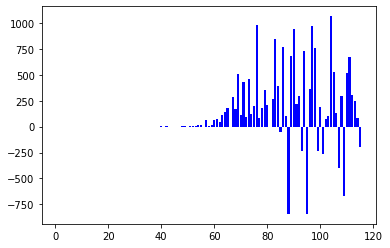

In [78]:
# check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    new_df, svm_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths_inc"
)

MAE: 3269.025454247208
MSE: 30023176.48644875
RMSE: 5479.340880657887
R^2: 0.9634492970427668


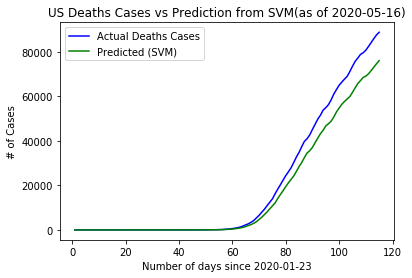

In [79]:
# generate predictions for death cases in US and compare it with the real values
plot_predictions_for_country(
    new_df, "US", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "US Deaths Cases vs Prediction from SVM",
    True
)

MAE: 1375.2966969820575
MSE: 4162011.892747398
RMSE: 2040.1009516069046
R^2: 0.962755691475733


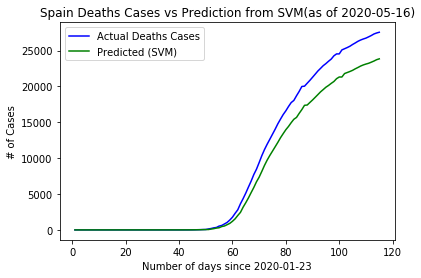

In [80]:
# generate predictions for death cases in Spain and compare it with the real values
plot_predictions_for_country(
    new_df, "Spain", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Spain Deaths Cases vs Prediction from SVM",
    True
)

MAE: 383.84964163179734
MSE: 615227.8996554684
RMSE: 784.3646471224137
R^2: 0.9566563461205781


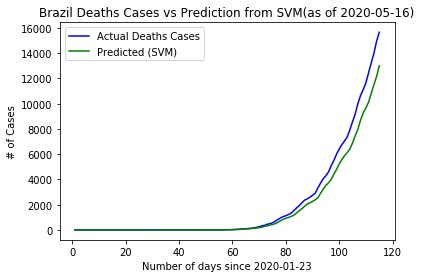

In [81]:
# generate predictions for death cases in Spain and compare it with the real values
plot_predictions_for_country(
    new_df, "Brazil", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Brazil Deaths Cases vs Prediction from SVM",
    True
)

MAE: 48.144818088643724
MSE: 5666.038829094378
RMSE: 75.27309498814552
R^2: 0.9690035380838852


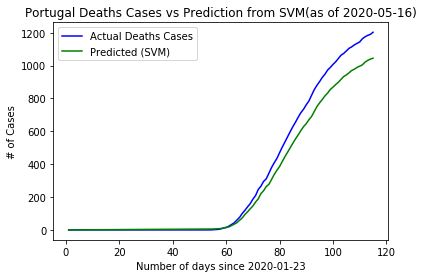

In [82]:
# generate predictions for death cases in Portugal and compare it with the real values
plot_predictions_for_country(
    new_df, "Portugal", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Portugal Deaths Cases vs Prediction from SVM",
    True
)

MAE: 61.72661115668221
MSE: 15790.19219593204
RMSE: 125.65903149368947
R^2: 0.9618554638848378


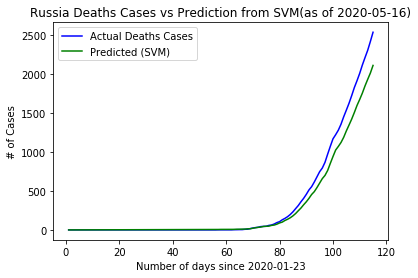

In [83]:
# generate predictions for death cases in Russia and compare it with the real values
plot_predictions_for_country(
    new_df, "Russia", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Russia Deaths Cases vs Prediction from SVM",
    True
)

MAE: 1658.234852707215
MSE: 5613427.801660896
RMSE: 2369.2673554626326
R^2: 0.9607916915669742


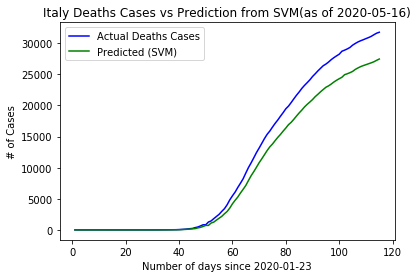

In [84]:
# generate predictions for death cases in Italy and compare it with the real values
plot_predictions_for_country(
    new_df, "Italy", svm_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SVM)", 
    "Italy Deaths Cases vs Prediction from SVM",
    True
)

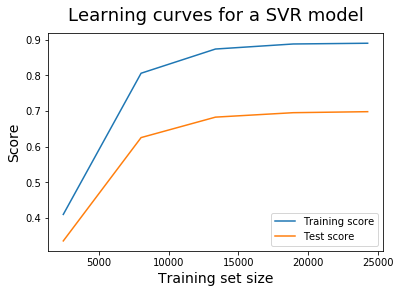

In [85]:
# compute the learning curve for the estimator, using the inputs and outputs
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

### 3.5.3) Regression for Recovered Cases
#### Using the best combination of parameters found for the confirmed cases, for SVM the best option was using increments in recovery cases and normalized values, using increments as output

In [86]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Recovered_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.12137308],
       [ 0.79830423, -0.03978737, -1.68731909, -0.12137308],
       [ 0.27177561, -0.30283255, -1.68731909, -0.12137308],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.12137308],
       [ 0.31790115,  1.38034566,  1.71718314, -0.12137308],
       [-1.65599721,  0.09994051,  1.71718314, -0.12137308]])

In [87]:
# get the output for the machine learning algorithm (recovery cases)
outputs = new_df["Recovered_inc"].values
outputs

array([ 0.,  0.,  0., ..., 59.,  0.,  0.])

In [88]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [89]:
# do hyper parameter tuning with the SVM, using cross validation
kernel = ['linear', 'poly', 'rbf']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
param_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'kernel': kernel}

search = RandomizedSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
svm_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
svm_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.6min finished


Elapsed time: 3.918893770376841mins
Best score: -155494.72454514797
Best parameters: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.01, 'C': 1}


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 33.61946603729533
MSE: 123850.48521641067
RMSE: 351.92397647277556
R^2: 0.3802687678856602


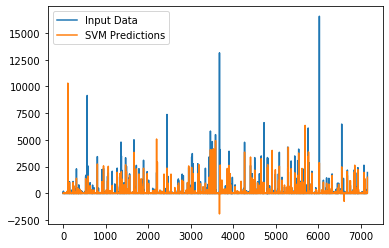

In [90]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(svm_estimator, in_conf_test, out_conf_test, 'SVM Predictions')

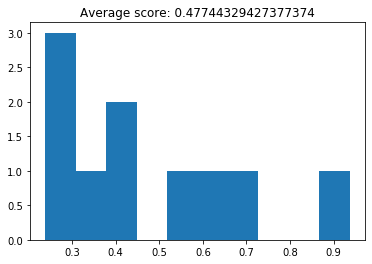

In [91]:
# check the score obtained by doing cross validation with the data
svm_estimator_2 = clone(svm_estimator)

plot_cross_val_score(svm_estimator_2, inputs, outputs, 10)

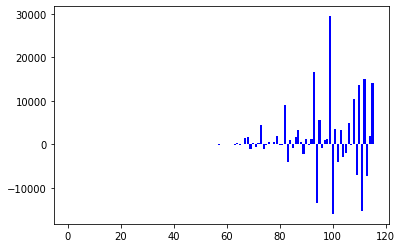

In [92]:
# check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    new_df, svm_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered_inc"
)

MAE: 11483.022231138519
MSE: 482137632.628876
RMSE: 21957.63267360295
R^2: 0.9140844224656963


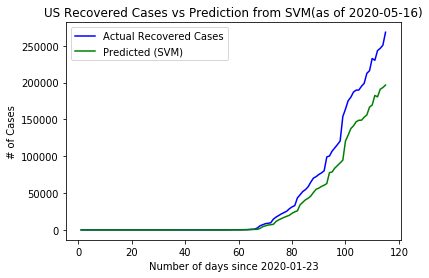

In [93]:
# generate predictions for recovery cases in US and compare it with the real values
plot_predictions_for_country(
    new_df, "US", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "US Recovered Cases vs Prediction from SVM",
    True
)

MAE: 9004.392923055384
MSE: 212542629.49887058
RMSE: 14578.84184353718
R^2: 0.9131750753789012


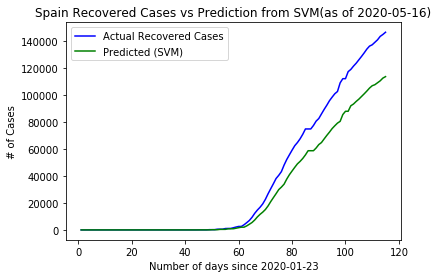

In [94]:
# generate predictions for recovery cases in Spain and compare it with the real values
plot_predictions_for_country(
    new_df, "Spain", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Spain Recovered Cases vs Prediction from SVM",
    True
)

MAE: 3202.942438298972
MSE: 44961674.689930975
RMSE: 6705.346724065131
R^2: 0.9111914085274334


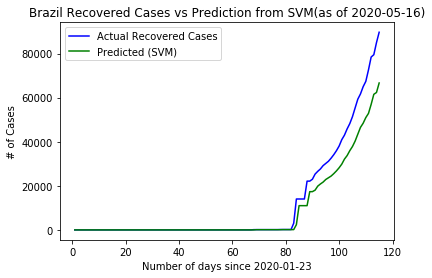

In [95]:
# generate predictions for recovery cases in Brazil and compare it with the real values
plot_predictions_for_country(
    new_df, "Brazil", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Brazil Recovered Cases vs Prediction from SVM",
    True
)

MAE: 134.83608245500815
MSE: 77110.1151159162
RMSE: 277.68708129100315
R^2: 0.9052303498680747


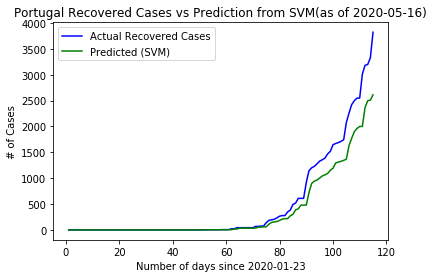

In [96]:
# generate predictions for recovery cases in Portugal and compare it with the real values
plot_predictions_for_country(
    new_df, "Portugal", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Portugal Recovered Cases vs Prediction from SVM",
    True
)

MAE: 1599.499736818388
MSE: 16197467.031929858
RMSE: 4024.6076867105767
R^2: 0.8996816510068465


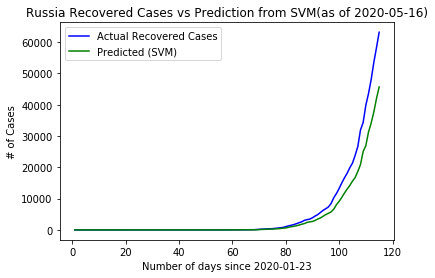

In [97]:
# generate predictions for recovery cases in Russia and compare it with the real values
plot_predictions_for_country(
    new_df, "Russia", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Russia Recovered Cases vs Prediction from SVM",
    True
)

MAE: 6467.818234984609
MSE: 115626082.73517716
RMSE: 10752.956929848513
R^2: 0.9096396173213306


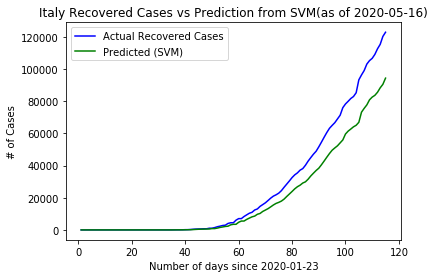

In [98]:
# generate predictions for recovery cases in Italy and compare it with the real values
plot_predictions_for_country(
    new_df, "Italy", svm_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SVM)", 
    "Italy Recovered Cases vs Prediction from SVM",
    True
)

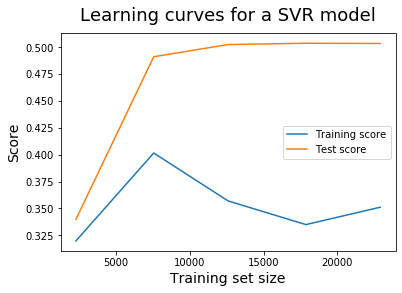

In [99]:
# compute the learning curve for the estimator, using the inputs and outputs
svm_estimator_2 = clone(svm_estimator)

plot_learning_curve(svm_estimator_2, inputs, outputs)

## 5) Conclusions

TODO

## 6) References

[Coronavirus (COVID-19) Visualization & Prediction](https://www.kaggle.com/therealcyberlord/coronavirus-covid-19-visualization-prediction/comments)

[Data-Analysis-and-Machine-Learning-Projects/Example Machine Learning Notebook.ipynb at master · rhiever/Data-Analysis-and-Machine-Learning-Projects](https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb)

[Random Forest Regression](https://towardsdatascience.com/random-forest-and-its-implementation-71824ced454f)

[Random Forest Regression Code](https://github.com/afrozchakure/Internity-Summer-Internship-Work/blob/master/Blogs/Random_Forest_Regression/Random_Forest_Regression.ipynb)

[Coronavirus (COVID-19) Visualization & Prediction](https://www.kaggle.com/therealcyberlord/coronavirus-covid-19-visualization-prediction)

[K-Fold Cross Validation Explained](https://medium.com/@zstern/k-fold-cross-validation-explained-5aeba90ebb3)

[Random Forest Regression using Scikit Learn](https://heartbeat.fritz.ai/random-forest-regression-in-python-using-scikit-learn-9e9b147e2153)

[Scikit Learn Documentation](https://scikit-learn.org/stable/)

[Mathplotlib Documentation](https://matplotlib.org/)

[Searborn Documentation](https://seaborn.pydata.org/)